In [2]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [4]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

In [5]:
# 발전량이 0인 시간대 (7시 이전, 17시 이후) 데이터는 제외
pv['time'] = [i.time() for i in pv['datetime']]
pv = pv[(pv['time']>=time(7, 0, 0)) & (pv['time']<time(17,0,0))]

# scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaler.fit(pv[['power']])

MinMaxScaler()

In [8]:
pv['power_scale'] = scaler.transform(pv[['power']])

In [9]:
pv = pv.set_index('datetime')

In [10]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,30,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,31,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [11]:
from torch.utils.data import DataLoader, Dataset

In [12]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2)) # (seq_len, output_window, feature)
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [13]:
iw = 10*7
ow = 10

train_dataset = windowDataset(pv_train['power_scale'], input_window=iw, output_window=ow, stride=10)
train_loader = DataLoader(train_dataset, batch_size=16)

# test_dataset = windowDataset(pv_test['power_scale'], input_window=iw, output_window=ow, stride=10)
# test_loader = DataLoader(test_dataset, batch_size=24)

In [14]:
len(train_loader)

23

# model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [57]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        # print(f"encoder input: {x_input.shape}")
        lstm_out, self.hidden = self.lstm(x_input) # self.hidden 은 (hidden_state, cell_state) 형식, hidden, cell 의 size 는 동일
        # print(f"encoder output: pred {lstm_out.shape} / hidden {self.hidden[0].shape} / cell {self.hidden[1].shape}")
        return lstm_out, self.hidden

In [58]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        # print(f"decoder input: {x_input.unsqueeze(-1).shape}")
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states) # 마지막 차원에 1차원 추가
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [59]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :] # 제일 마지막 시점의 (seq_len, feature_dim)
        # print((hidden[0].shape), (hidden[1].shape))
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            # print(len(out), len(hidden))
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :] # 제일 마지막 시점의 (seq_len, feature_dim)
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [60]:
device='cuda'
# input size: x feature 사용할 경우 변경

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)

In [61]:
learning_rate=0.01
epoch = 1
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [62]:
from tqdm.auto import tqdm
import random

In [66]:
a = torch.rand([3,3,2])

In [74]:
a[:,2,:]

tensor([[0.3164, 0.4160],
        [0.4921, 0.6110],
        [0.5164, 0.0398]])

In [69]:
a[:,-1,:]

tensor([[0.3164, 0.4160],
        [0.4921, 0.6110],
        [0.5164, 0.0398]])

In [63]:
model.train()

pbar = tqdm(range(epoch))
for i in pbar:
    total_loss = 0.0
    for x,y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()
        output = model(x, y, ow, 0.6).to(device)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()
    pbar.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

  0%|          | 0/1 [00:00<?, ?it/s]

incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])
decoder input: torch.Size([16, 1])
incoder input: torch.Size([16, 70, 1])

In [42]:
predict = model.predict(torch.tensor(pv_train[-10*7:]['power_scale']).reshape(-1,1).to(device).float(), target_len=ow)
real = np.array(pv_test['power_scale'])

predict = scaler.inverse_transform(predict.reshape(-1,1))
real = scaler.inverse_transform(real.reshape(-1,1))

In [43]:
pv_test.shape

(10, 19)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


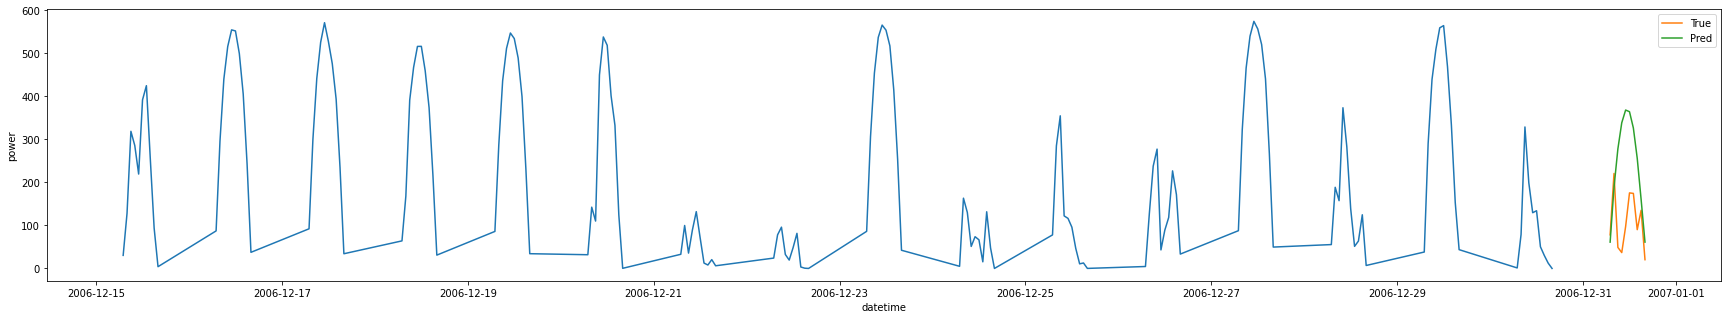

In [44]:
import seaborn as sns

plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, real.reshape(-1), label='True')
sns.lineplot(pv_test.index, predict.reshape(-1), label='Pred')
plt.legend()